# Modèle 1: CNN Custom avec Explainability

**Architecture CNN personnalisée avec:**
- 4 blocs convolutionnels (3→64→128→256→512 canaux)
- Batch Normalization pour stabilité
- Dropout pour régularisation
- Global Average Pooling
- Grad-CAM pour l'explicabilité

**Dataset:** 2200 images (11 classes d'épices)  
**Split:** 70% train / 15% val / 15% test

In [6]:
# Cellule 1 - Vérification de l'environnement
import sys
print(f"Python executable: {sys.executable}")
print(f"Python version: {sys.version}")

# Installation de PyTorch si nécessaire
try:
    import torch
    print(f"✅ PyTorch {torch.__version__} already installed")
except ImportError:
    print("⚠️ Installing PyTorch...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", 
                          "torch==2.0.0", "torchvision==0.15.1", 
                          "--break-system-packages"])
    import torch
    print(f"✅ PyTorch {torch.__version__} installed successfully")

Python executable: c:\Users\pc\AppData\Local\Programs\Python\Python310\python.exe
Python version: 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
✅ PyTorch 2.0.0+cpu already installed


In [10]:
# ====================================
# IMPORTS
# ====================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Configuration device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Device: {device}")
print(f"   PyTorch version: {torch.__version__}")
print(f"   CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   CUDA device: {torch.cuda.get_device_name(0)}")

🖥️  Device: cpu
   PyTorch version: 2.0.0+cpu
   CUDA available: False


## 1. Dataset et DataLoader

In [11]:
# ====================================
# DATASET CLASS
# ====================================
class SpiceDataset(Dataset):
    """
    Dataset personnalisé pour les épices.
    Charge les images depuis la structure: root_dir/class_name/*.jpg
    """
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.images = []
        self.labels = []
        
        # Récupérer les noms de classes (dossiers)
        self.class_names = sorted([d.name for d in self.root_dir.iterdir() if d.is_dir()])
        self.class_to_idx = {name: idx for idx, name in enumerate(self.class_names)}
        
        # Charger tous les chemins d'images
        for class_name in self.class_names:
            class_dir = self.root_dir / class_name
            for img_path in class_dir.glob('*.jpg'):
                self.images.append(img_path)
                self.labels.append(self.class_to_idx[class_name])
        
        print(f"   ✅ Loaded {len(self.images)} images from {root_dir}")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Charger l'image
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        # Appliquer les transformations
        if self.transform:
            image = self.transform(image)
        
        return image, label

print("✅ Dataset class définie")

✅ Dataset class définie


In [12]:
# ====================================
# TRANSFORMATIONS (AUGMENTATION)
# ====================================
print("\n📋 Configuration des transformations d'images...\n")

# Train: Augmentation aggressive
train_transform = transforms.Compose([
    # 1. Géométriques (sur PIL Image)
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.LANCZOS),
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    
    # 2. Couleur/Lumière (sur PIL Image)
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAutocontrast(p=0.3),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.3),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.5)),
    
    # 3. Conversion PIL → Tensor (CRUCIAL!)
    transforms.ToTensor(),
    
    # 4. Augmentation sur Tensor
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1)),
    
    # 5. Normalisation ImageNet
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Val/Test: Pas d'augmentation
val_transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.LANCZOS),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("   ✅ Train transform: 10 augmentations")
print("   ✅ Val/Test transform: Normalisation seulement")


📋 Configuration des transformations d'images...

   ✅ Train transform: 10 augmentations
   ✅ Val/Test transform: Normalisation seulement


In [13]:
# ====================================
# CLASSE DATASET PERSONNALISÉE
# ====================================
from torch.utils.data import Dataset
from pathlib import Path
from PIL import Image

class SpiceDataset(Dataset):
    """Dataset personnalisé pour les images d'épices"""
    
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Chemin vers le dossier contenant les sous-dossiers de classes
            transform: Transformations à appliquer aux images
        """
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.images = []
        self.labels = []
        
        # Récupérer les noms de classes (dossiers)
        self.class_names = sorted([d.name for d in self.root_dir.iterdir() if d.is_dir()])
        self.class_to_idx = {name: idx for idx, name in enumerate(self.class_names)}
        
        # Charger tous les chemins d'images
        for class_name in self.class_names:
            class_dir = self.root_dir / class_name
            class_idx = self.class_to_idx[class_name]
            
            # Extensions d'images supportées
            for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']:
                for img_path in class_dir.glob(ext):
                    self.images.append(img_path)
                    self.labels.append(class_idx)
        
        print(f"   ✅ Chargé {len(self.images)} images de {len(self.class_names)} classes")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Charger l'image
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        # Appliquer les transformations
        if self.transform:
            image = self.transform(image)
        
        return image, label

print("✅ Classe SpiceDataset définie !")

✅ Classe SpiceDataset définie !


In [14]:
# ====================================
# CRÉATION DES DATASETS ET DATALOADERS
# ====================================
print("\n📂 Chargement des datasets...\n")

# Créer les datasets
train_dataset = SpiceDataset('C:\\Users\\pc\\Desktop\\Spices-classification-main\\data_spices\\test', transform=train_transform)
val_dataset = SpiceDataset('C:\\Users\\pc\\Desktop\\Spices-classification-main\\data_spices\\val', transform=val_transform)
test_dataset = SpiceDataset('C:\\Users\\pc\\Desktop\\Spices-classification-main\\data_spices\\test', transform=val_transform)

print(f"\n   📊 Classes ({len(train_dataset.class_names)}): {train_dataset.class_names}")
print(f"   📊 Train: {len(train_dataset)} images")
print(f"   📊 Val: {len(val_dataset)} images")
print(f"   📊 Test: {len(test_dataset)} images")

# Créer les data loaders
batch_size = 32

# IMPORTANT : Sur Windows, num_workers=0 pour éviter les blocages
num_workers = 0  # ⚠️ Changé de 2 à 0 pour Windows
pin_memory = torch.cuda.is_available()

print("\n⚙️ Configuration DataLoader...")
print(f"   ℹ️ num_workers=0 (recommandé pour Windows)")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                         num_workers=num_workers, pin_memory=pin_memory)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                       num_workers=num_workers, pin_memory=pin_memory)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, 
                        num_workers=num_workers, pin_memory=pin_memory)

print(f"\n   ✅ Batch size: {batch_size}")
print(f"   ✅ Num workers: {num_workers}")
print(f"   ✅ Pin memory: {pin_memory}")
print(f"   ✅ Train batches: {len(train_loader)}")
print(f"   ✅ Val batches: {len(val_loader)}")
print(f"   ✅ Test batches: {len(test_loader)}")

# Vérification du format de sortie
print("\n🔍 Vérification du format des données...")
sample_batch, sample_labels = next(iter(train_loader))
print(f"   ✅ Batch shape: {sample_batch.shape}")
print(f"   ✅ Batch dtype: {sample_batch.dtype}")
print(f"   ✅ Batch range: [{sample_batch.min():.3f}, {sample_batch.max():.3f}]")
print(f"   ✅ Labels shape: {sample_labels.shape}")
assert sample_batch.shape[1:] == (3, 224, 224), "Shape incorrecte!"
print("\n✅✅✅ Format des données VALIDÉ!\n")


📂 Chargement des datasets...

   ✅ Chargé 660 images de 11 classes
   ✅ Chargé 660 images de 11 classes
   ✅ Chargé 660 images de 11 classes

   📊 Classes (11): ['anis', 'cannelle', 'carvi', 'clou_girofle', 'cubebe', 'cumin', 'curcuma', 'gingembre', 'paprika', 'poivre noir', 'safran']
   📊 Train: 660 images
   📊 Val: 660 images
   📊 Test: 660 images

⚙️ Configuration DataLoader...
   ℹ️ num_workers=0 (recommandé pour Windows)

   ✅ Batch size: 32
   ✅ Num workers: 0
   ✅ Pin memory: False
   ✅ Train batches: 21
   ✅ Val batches: 21
   ✅ Test batches: 21

🔍 Vérification du format des données...
   ✅ Batch shape: torch.Size([32, 3, 224, 224])
   ✅ Batch dtype: torch.float32
   ✅ Batch range: [-2.118, 2.640]
   ✅ Labels shape: torch.Size([32])

✅✅✅ Format des données VALIDÉ!



## 2. Architecture CNN Custom

In [15]:
# ====================================
# ARCHITECTURE CNN CUSTOM
# ====================================
class CustomCNN(nn.Module):
    """
    CNN Custom à 4 blocs avec architecture progressive:
    - Block 1: 3 → 64 canaux (détection features simples)
    - Block 2: 64 → 128 canaux (combinaison features)
    - Block 3: 128 → 256 canaux (patterns locaux)
    - Block 4: 256 → 512 canaux (patterns globaux)
    - Global Average Pooling
    - Classifier: 512 → 256 → 11 classes
    """
    def __init__(self, num_classes=11):
        super(CustomCNN, self).__init__()
        
        # Block 1: 3 → 64 (détection arêtes, couleurs)
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 224×224 → 112×112
        )
        
        # Block 2: 64 → 128 (formes locales)
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 112×112 → 56×56
        )
        
        # Block 3: 128 → 256 (objets locaux)
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 56×56 → 28×28
        )
        
        # Block 4: 256 → 512 (structure globale)
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 28×28 → 14×14
        )
        
        # Global Average Pooling: 14×14×512 → 512
        self.gap = nn.AdaptiveAvgPool2d(1)
        
        # Classifier avec régularisation forte
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
        
        # Variables pour Grad-CAM
        self.gradients = None
        self.activations = None
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        
        # Sauvegarder activations pour Grad-CAM
        if x.requires_grad:
            x.register_hook(self.save_gradient)
        self.activations = x
        
        # Global Average Pooling + Classifier
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
    def save_gradient(self, grad):
        """Hook pour sauvegarder les gradients (Grad-CAM)"""
        self.gradients = grad


# Créer le modèle
print("\n🏗️  Création du modèle CNN Custom...\n")
model = CustomCNN(num_classes=11).to(device)

# Compter les paramètres
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(model)
print(f"\n📊 Statistiques du modèle:")
print(f"   Total paramètres: {total_params:,}")
print(f"   Paramètres entraînables: {trainable_params:,}")
print(f"   Taille estimée: ~{total_params * 4 / 1024 / 1024:.1f} MB (float32)")


🏗️  Création du modèle CNN Custom...

CustomCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, 

## 3. Entraînement du Modèle

In [17]:
# ====================================
# CONFIGURATION DE L'ENTRAÎNEMENT
# ====================================
from torch.cuda.amp import GradScaler, autocast

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Device: {device}")

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=3, factor=0.5
)

# Mixed Precision Training (pour GPU uniquement)
# Sur CPU, GradScaler ne fait rien mais évite les erreurs
scaler = GradScaler(enabled=torch.cuda.is_available())

# Hyperparamètres
num_epochs = 30

print(f"✅ Optimizer: Adam (lr=0.001)")
print(f"✅ Scheduler: ReduceLROnPlateau")
print(f"✅ Mixed Precision: {'Activé (GPU)' if torch.cuda.is_available() else 'Désactivé (CPU)'}")
print(f"✅ Epochs: {num_epochs}")

🖥️  Device: cpu
✅ Optimizer: Adam (lr=0.001)
✅ Scheduler: ReduceLROnPlateau
✅ Mixed Precision: Désactivé (CPU)
✅ Epochs: 30


In [18]:
# ====================================
# CONFIGURATION ENTRAÎNEMENT
# ====================================
print("\n⚙️  Configuration de l'entraînement...\n")

# Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=3, factor=0.5
)

# OPTIMIZATION: Add GradScaler for Mixed Precision
scaler = GradScaler()

# Hyperparamètres
num_epochs = 30
best_val_acc = 0
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

print(f"   ✅ Loss: CrossEntropyLoss")
print(f"   ✅ Optimizer: Adam (lr=0.001)")
print(f"   ✅ Scheduler: ReduceLROnPlateau (patience=3, factor=0.5)")
print(f"   ✅ Mixed Precision: Enabled (via GradScaler)")
print(f"   ✅ Epochs: {num_epochs}")
print(f"   ✅ Best model will be saved to: model_cnn_custom_best.pth\n")


⚙️  Configuration de l'entraînement...

   ✅ Loss: CrossEntropyLoss
   ✅ Optimizer: Adam (lr=0.001)
   ✅ Scheduler: ReduceLROnPlateau (patience=3, factor=0.5)
   ✅ Mixed Precision: Enabled (via GradScaler)
   ✅ Epochs: 30
   ✅ Best model will be saved to: model_cnn_custom_best.pth



c:\Users\pc\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\cuda\amp\grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


In [19]:
# ====================================
# FONCTIONS D'ENTRAÎNEMENT
# ====================================
from torch.cuda.amp import autocast, GradScaler

def train_epoch(model, loader, criterion, optimizer, scaler, device):
    """Entraîner le modèle sur une epoch avec Mixed Precision"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc='Training', leave=False)
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass with autocast
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        # Backward pass with scaler
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # Métriques
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100. * correct / total:.2f}%'
        })
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc


def validate(model, loader, criterion, device):
    """Évaluer le modèle sur validation/test set avec Mixed Precision"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Validation', leave=False):
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass with autocast
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            # Métriques
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc


print("✅ Fonctions d'entraînement définies (avec Mixed Precision)")

✅ Fonctions d'entraînement définies (avec Mixed Precision)


In [21]:
# ====================================
# BOUCLE D'ENTRAÎNEMENT
# ====================================
from pathlib import Path

# Créer le dossier models s'il n'existe pas
models_dir = Path('../models')
models_dir.mkdir(parents=True, exist_ok=True)

print("\n" + "="*60)
print("🔥 DÉBUT DE L'ENTRAÎNEMENT")
print("="*60)
print(f"📁 Dossier de sauvegarde : {models_dir.absolute()}\n")

for epoch in range(num_epochs):
    print(f"\n{'='*60}")
    print(f"📍 Epoch {epoch+1}/{num_epochs}")
    print(f"{'='*60}")
    
    # Train (pass scaler)
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scaler, device)
    
    # Validation
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # Sauvegarder l'historique
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Afficher les résultats
    print(f"\n📊 Résultats Epoch {epoch+1}:")
    print(f"   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"   Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    
    # Learning rate scheduler
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"   Learning Rate: {current_lr:.6f}")
    
    # Sauvegarder le meilleur modèle
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        save_path = models_dir / 'model_cnn_custom_best.pth'
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'train_acc': train_acc,
            'train_loss': train_loss,
            'class_names': train_dataset.class_names
        }, save_path)
        print(f"   ✅ Nouveau meilleur modèle sauvegardé! Val Acc: {val_acc:.2f}%")
        print(f"   💾 Fichier : {save_path.name}")

print("\n" + "="*60)
print(f"✅ ENTRAÎNEMENT TERMINÉ!")
print(f"   Meilleure Val Accuracy: {best_val_acc:.2f}%")
print(f"   📁 Modèle sauvegardé dans : {models_dir / 'model_cnn_custom_best.pth'}")
print("="*60 + "\n")


🔥 DÉBUT DE L'ENTRAÎNEMENT
📁 Dossier de sauvegarde : c:\Users\pc\Desktop\Spices-classification-main\notebooks\..\models


📍 Epoch 1/30



📊 Résultats Epoch 1:
   Train Loss: 1.6870 | Train Acc: 40.15%
   Val Loss:   3.7241 | Val Acc:   37.88%
   Learning Rate: 0.001000
   ✅ Nouveau meilleur modèle sauvegardé! Val Acc: 37.88%
   💾 Fichier : model_cnn_custom_best.pth

📍 Epoch 2/30



📊 Résultats Epoch 2:
   Train Loss: 1.4330 | Train Acc: 47.12%
   Val Loss:   1.4625 | Val Acc:   51.21%
   Learning Rate: 0.001000
   ✅ Nouveau meilleur modèle sauvegardé! Val Acc: 51.21%
   💾 Fichier : model_cnn_custom_best.pth

📍 Epoch 3/30



📊 Résultats Epoch 3:
   Train Loss: 1.2705 | Train Acc: 53.33%
   Val Loss:   1.9227 | Val Acc:   37.58%
   Learning Rate: 0.001000

📍 Epoch 4/30



📊 Résultats Epoch 4:
   Train Loss: 1.3388 | Train Acc: 51.82%
   Val Loss:   1.6477 | Val Acc:   50.61%
   Learning Rate: 0.001000

📍 Epoch 5/30



📊 Résultats Epoch 5:
   Train Loss: 1.2248 | Train Acc: 56.82%
   Val Loss:   1.2166 | Val Acc:   56.97%
   Learning Rate: 0.001000
   ✅ Nouveau meilleur modèle sauvegardé! Val Acc: 56.97%
   💾 Fichier : model_cnn_custom_best.pth

📍 Epoch 6/30



📊 Résultats Epoch 6:
   Train Loss: 1.1737 | Train Acc: 55.45%
   Val Loss:   1.2473 | Val Acc:   59.70%
   Learning Rate: 0.001000
   ✅ Nouveau meilleur modèle sauvegardé! Val Acc: 59.70%
   💾 Fichier : model_cnn_custom_best.pth

📍 Epoch 7/30



📊 Résultats Epoch 7:
   Train Loss: 1.1075 | Train Acc: 59.24%
   Val Loss:   1.2073 | Val Acc:   60.61%
   Learning Rate: 0.001000
   ✅ Nouveau meilleur modèle sauvegardé! Val Acc: 60.61%
   💾 Fichier : model_cnn_custom_best.pth

📍 Epoch 8/30



📊 Résultats Epoch 8:
   Train Loss: 1.1098 | Train Acc: 61.36%
   Val Loss:   1.1390 | Val Acc:   62.73%
   Learning Rate: 0.001000
   ✅ Nouveau meilleur modèle sauvegardé! Val Acc: 62.73%
   💾 Fichier : model_cnn_custom_best.pth

📍 Epoch 9/30



📊 Résultats Epoch 9:
   Train Loss: 0.9724 | Train Acc: 66.21%
   Val Loss:   1.2145 | Val Acc:   60.00%
   Learning Rate: 0.001000

📍 Epoch 10/30



📊 Résultats Epoch 10:
   Train Loss: 0.9314 | Train Acc: 64.70%
   Val Loss:   1.6360 | Val Acc:   53.03%
   Learning Rate: 0.001000

📍 Epoch 11/30



📊 Résultats Epoch 11:
   Train Loss: 1.0469 | Train Acc: 64.09%
   Val Loss:   1.1276 | Val Acc:   64.55%
   Learning Rate: 0.001000
   ✅ Nouveau meilleur modèle sauvegardé! Val Acc: 64.55%
   💾 Fichier : model_cnn_custom_best.pth

📍 Epoch 12/30



📊 Résultats Epoch 12:
   Train Loss: 0.9593 | Train Acc: 66.82%
   Val Loss:   1.1935 | Val Acc:   62.42%
   Learning Rate: 0.001000

📍 Epoch 13/30



📊 Résultats Epoch 13:
   Train Loss: 0.9439 | Train Acc: 67.88%
   Val Loss:   1.1074 | Val Acc:   62.42%
   Learning Rate: 0.001000

📍 Epoch 14/30



📊 Résultats Epoch 14:
   Train Loss: 0.8602 | Train Acc: 70.15%
   Val Loss:   1.4509 | Val Acc:   55.15%
   Learning Rate: 0.001000

📍 Epoch 15/30



📊 Résultats Epoch 15:
   Train Loss: 0.8988 | Train Acc: 67.12%
   Val Loss:   1.2677 | Val Acc:   59.09%
   Learning Rate: 0.001000

📍 Epoch 16/30



📊 Résultats Epoch 16:
   Train Loss: 0.8712 | Train Acc: 69.70%
   Val Loss:   1.6323 | Val Acc:   58.18%
   Learning Rate: 0.001000

📍 Epoch 17/30



📊 Résultats Epoch 17:
   Train Loss: 0.8082 | Train Acc: 71.21%
   Val Loss:   1.0750 | Val Acc:   63.94%
   Learning Rate: 0.001000

📍 Epoch 18/30



📊 Résultats Epoch 18:
   Train Loss: 0.8621 | Train Acc: 69.85%
   Val Loss:   1.4413 | Val Acc:   63.33%
   Learning Rate: 0.001000

📍 Epoch 19/30



📊 Résultats Epoch 19:
   Train Loss: 0.8130 | Train Acc: 71.97%
   Val Loss:   1.0833 | Val Acc:   68.18%
   Learning Rate: 0.001000
   ✅ Nouveau meilleur modèle sauvegardé! Val Acc: 68.18%
   💾 Fichier : model_cnn_custom_best.pth

📍 Epoch 20/30



📊 Résultats Epoch 20:
   Train Loss: 0.7568 | Train Acc: 72.12%
   Val Loss:   0.9705 | Val Acc:   69.09%
   Learning Rate: 0.001000
   ✅ Nouveau meilleur modèle sauvegardé! Val Acc: 69.09%
   💾 Fichier : model_cnn_custom_best.pth

📍 Epoch 21/30



📊 Résultats Epoch 21:
   Train Loss: 0.8113 | Train Acc: 69.55%
   Val Loss:   1.1692 | Val Acc:   67.27%
   Learning Rate: 0.001000

📍 Epoch 22/30



📊 Résultats Epoch 22:
   Train Loss: 0.8591 | Train Acc: 70.30%
   Val Loss:   0.9735 | Val Acc:   69.70%
   Learning Rate: 0.001000
   ✅ Nouveau meilleur modèle sauvegardé! Val Acc: 69.70%
   💾 Fichier : model_cnn_custom_best.pth

📍 Epoch 23/30



📊 Résultats Epoch 23:
   Train Loss: 0.7648 | Train Acc: 72.88%
   Val Loss:   0.9949 | Val Acc:   71.82%
   Learning Rate: 0.001000
   ✅ Nouveau meilleur modèle sauvegardé! Val Acc: 71.82%
   💾 Fichier : model_cnn_custom_best.pth

📍 Epoch 24/30



📊 Résultats Epoch 24:
   Train Loss: 0.7617 | Train Acc: 75.45%
   Val Loss:   1.2118 | Val Acc:   66.36%
   Learning Rate: 0.000500

📍 Epoch 25/30



📊 Résultats Epoch 25:
   Train Loss: 0.7093 | Train Acc: 75.30%
   Val Loss:   0.9737 | Val Acc:   70.61%
   Learning Rate: 0.000500

📍 Epoch 26/30



📊 Résultats Epoch 26:
   Train Loss: 0.6479 | Train Acc: 75.91%
   Val Loss:   1.0088 | Val Acc:   70.91%
   Learning Rate: 0.000500

📍 Epoch 27/30



📊 Résultats Epoch 27:
   Train Loss: 0.6199 | Train Acc: 77.42%
   Val Loss:   0.8380 | Val Acc:   76.06%
   Learning Rate: 0.000500
   ✅ Nouveau meilleur modèle sauvegardé! Val Acc: 76.06%
   💾 Fichier : model_cnn_custom_best.pth

📍 Epoch 28/30



📊 Résultats Epoch 28:
   Train Loss: 0.5663 | Train Acc: 79.85%
   Val Loss:   0.9277 | Val Acc:   72.12%
   Learning Rate: 0.000500

📍 Epoch 29/30



📊 Résultats Epoch 29:
   Train Loss: 0.5627 | Train Acc: 79.55%
   Val Loss:   0.8978 | Val Acc:   75.15%
   Learning Rate: 0.000500

📍 Epoch 30/30



📊 Résultats Epoch 30:
   Train Loss: 0.5401 | Train Acc: 79.55%
   Val Loss:   1.0353 | Val Acc:   70.61%
   Learning Rate: 0.000500

✅ ENTRAÎNEMENT TERMINÉ!
   Meilleure Val Accuracy: 76.06%
   📁 Modèle sauvegardé dans : ..\models\model_cnn_custom_best.pth



## 4. Visualisation des Résultats

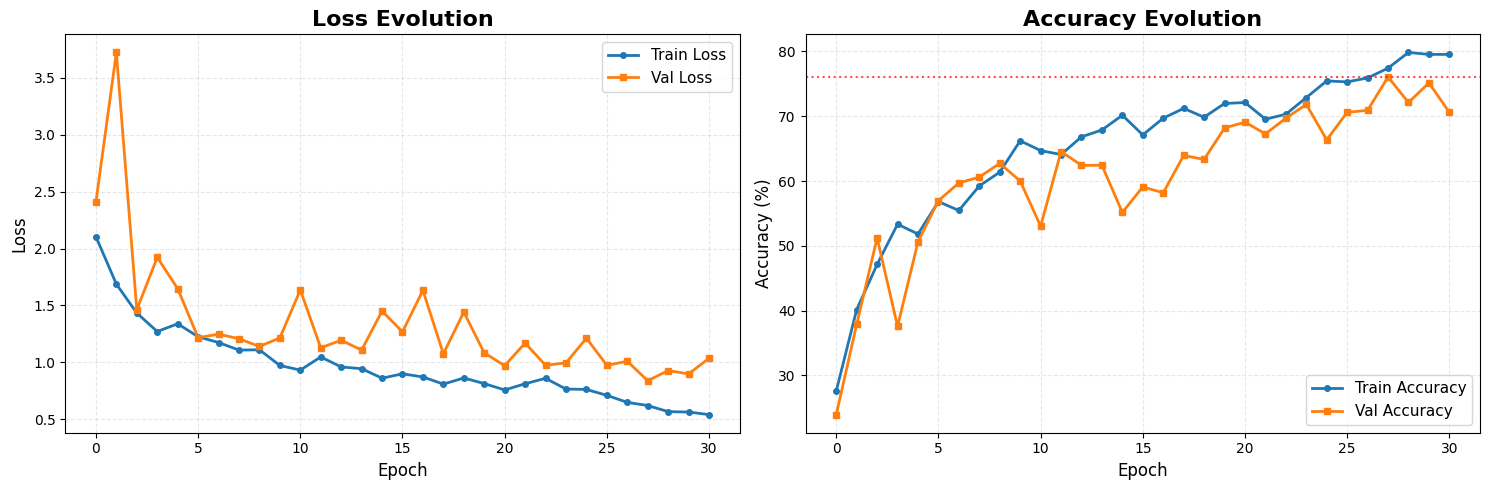

✅ Graphiques sauvegardés: ../models/training_curves_cnn_custom.png


In [22]:
# ====================================
# VISUALISATION LOSS & ACCURACY
# ====================================
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2, marker='o', markersize=4)
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2, marker='s', markersize=4)
axes[0].set_title('Loss Evolution', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3, linestyle='--')

# Accuracy plot
axes[1].plot(history['train_acc'], label='Train Accuracy', linewidth=2, marker='o', markersize=4)
axes[1].plot(history['val_acc'], label='Val Accuracy', linewidth=2, marker='s', markersize=4)
axes[1].set_title('Accuracy Evolution', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3, linestyle='--')
axes[1].axhline(y=best_val_acc, color='red', linestyle=':', label=f'Best: {best_val_acc:.2f}%', alpha=0.7)

plt.tight_layout()
plt.savefig('../models/training_curves_cnn_custom.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Graphiques sauvegardés: ../models/training_curves_cnn_custom.png")

## 5. Évaluation sur le Test Set

In [24]:
# ====================================
# ÉVALUATION SUR TEST SET
# ====================================
from pathlib import Path

print("\n📊 Évaluation sur le Test Set...\n")

# Charger le meilleur modèle
models_dir = Path('../models')
model_path = models_dir / 'model_cnn_custom_best.pth'

print(f"🔍 Recherche du modèle à : {model_path.absolute()}")

if not model_path.exists():
    print(f"\n❌ ERREUR : Le modèle n'existe pas !")
    print(f"   Chemin recherché : {model_path.absolute()}")
    print("\n💡 Solutions possibles :")
    print("   1. Attendez la fin complète de l'entraînement")
    print("   2. Vérifiez que le modèle a bien été sauvegardé pendant l'entraînement")
    print("   3. Vérifiez le dossier models/")
    
    # Chercher le fichier ailleurs
    print("\n🔎 Recherche du fichier dans le projet...")
    project_root = Path.cwd().parent
    for pth_file in project_root.rglob('model_cnn_custom_best.pth'):
        print(f"   ✅ Trouvé : {pth_file}")
else:
    # Charger le modèle
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✅ Meilleur modèle chargé (Epoch {checkpoint['epoch']}, Val Acc: {checkpoint['val_acc']:.2f}%)\n")

    # Évaluation
    model.eval()
    all_preds = []
    all_labels = []

    print("🧪 Évaluation en cours...")
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Testing'):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Accuracy
    test_acc = 100. * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    print(f"\n🎯 Test Accuracy: {test_acc:.2f}%\n")

    # Classification Report
    print("="*70)
    print("📋 CLASSIFICATION REPORT")
    print("="*70)
    print(classification_report(
        all_labels, all_preds, 
        target_names=train_dataset.class_names,
        digits=4
    ))


📊 Évaluation sur le Test Set...

🔍 Recherche du modèle à : c:\Users\pc\Desktop\Spices-classification-main\notebooks\..\models\model_cnn_custom_best.pth
✅ Meilleur modèle chargé (Epoch 27, Val Acc: 76.06%)

🧪 Évaluation en cours...


Testing: 100%|██████████| 21/21 [02:41<00:00,  7.67s/it]


🎯 Test Accuracy: 85.45%

📋 CLASSIFICATION REPORT
              precision    recall  f1-score   support

        anis     0.9677    1.0000    0.9836        60
    cannelle     0.7714    0.9000    0.8308        60
       carvi     1.0000    1.0000    1.0000        60
clou_girofle     0.8182    0.3000    0.4390        60
      cubebe     0.9677    1.0000    0.9836        60
       cumin     1.0000    0.7667    0.8679        60
     curcuma     1.0000    1.0000    1.0000        60
   gingembre     0.8182    0.9000    0.8571        60
     paprika     0.9355    0.9667    0.9508        60
 poivre noir     0.5278    0.6333    0.5758        60
      safran     0.7179    0.9333    0.8116        60

    accuracy                         0.8545       660
   macro avg     0.8659    0.8545    0.8455       660
weighted avg     0.8659    0.8545    0.8455       660



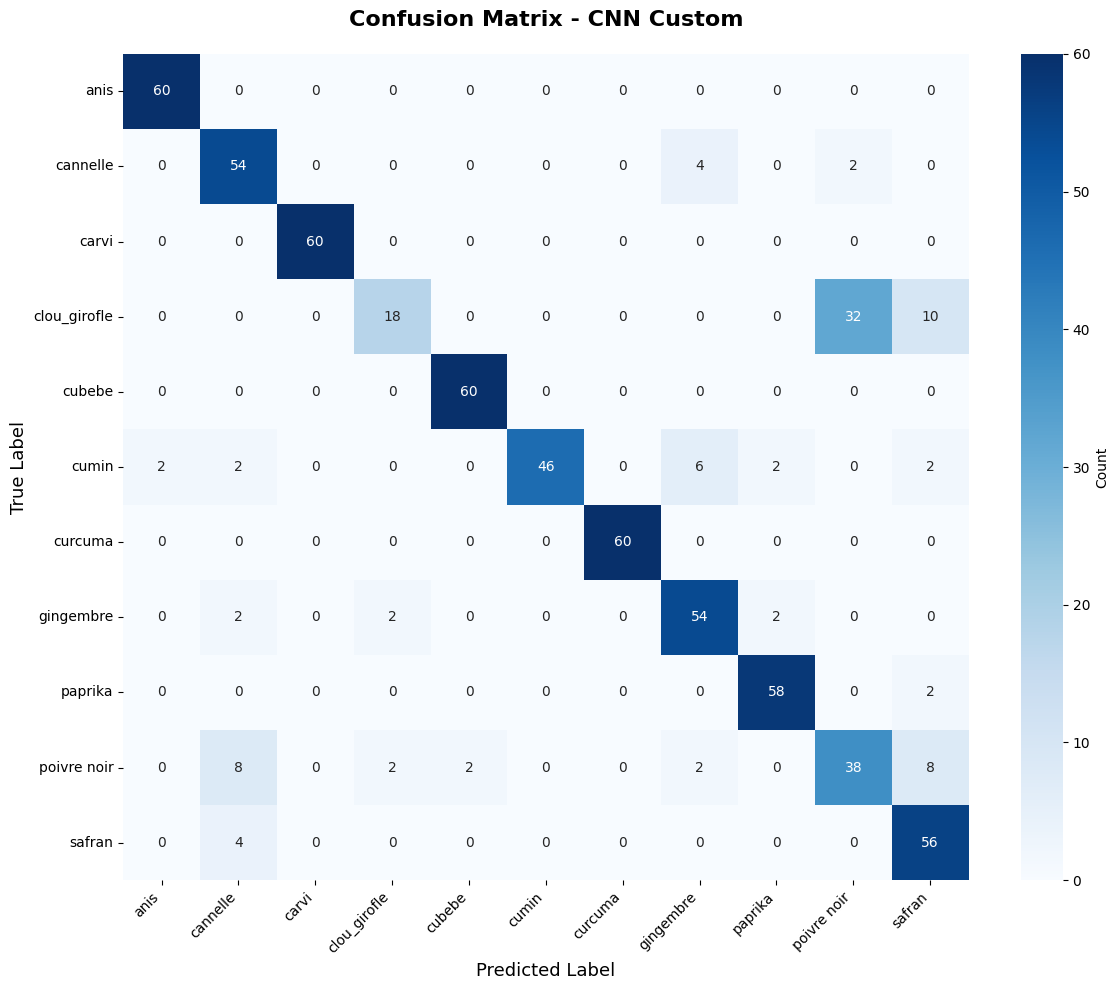

✅ Matrice de confusion sauvegardée: ../models/confusion_matrix_cnn_custom.png


In [25]:
# ====================================
# MATRICE DE CONFUSION
# ====================================
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=train_dataset.class_names,
    yticklabels=train_dataset.class_names,
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - CNN Custom', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=13)
plt.xlabel('Predicted Label', fontsize=13)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('../models/confusion_matrix_cnn_custom.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Matrice de confusion sauvegardée: ../models/confusion_matrix_cnn_custom.png")

## 6. Explainability: Grad-CAM

Grad-CAM (Gradient-weighted Class Activation Mapping) permet de visualiser quelles régions de l'image sont importantes pour la prédiction du modèle.

In [26]:
# ====================================
# GRAD-CAM IMPLEMENTATION
# ====================================
def generate_gradcam(model, image, target_class):
    """
    Génère une heatmap Grad-CAM pour une image et une classe cible.
    
    Args:
        model: Le modèle CNN
        image: Image tensor (C, H, W)
        target_class: Classe cible (int)
    
    Returns:
        cam: Heatmap Grad-CAM (H, W)
    """
    model.eval()
    image = image.unsqueeze(0).to(device)
    image.requires_grad = True
    
    # Forward pass
    output = model(image)
    
    # Backward pass sur la classe cible
    model.zero_grad()
    output[0, target_class].backward()
    
    # Récupérer gradients et activations
    gradients = model.gradients.cpu().data.numpy()[0]  # (512, 14, 14)
    activations = model.activations.cpu().data.numpy()[0]  # (512, 14, 14)
    
    # Calculer les poids (global average pooling des gradients)
    weights = np.mean(gradients, axis=(1, 2))  # (512,)
    
    # Calculer la CAM (weighted sum des activations)
    cam = np.zeros(activations.shape[1:], dtype=np.float32)  # (14, 14)
    for i, w in enumerate(weights):
        cam += w * activations[i]
    
    # ReLU (garder seulement les contributions positives)
    cam = np.maximum(cam, 0)
    
    # Normaliser entre 0 et 1
    if cam.max() > 0:
        cam = cam / cam.max()
    
    # Redimensionner à la taille de l'image originale
    cam = cv2.resize(cam, (224, 224))
    
    return cam


def denormalize_image(tensor):
    """Dénormalise un tensor d'image (inverse ImageNet normalization)"""
    img = tensor.cpu().numpy().transpose(1, 2, 0)
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    return img


def show_gradcam(image, cam, title, save_path=None):
    """
    Affiche l'image originale, la heatmap Grad-CAM, et la superposition.
    
    Args:
        image: Image tensor (C, H, W)
        cam: Heatmap Grad-CAM (H, W)
        title: Titre pour la visualisation
        save_path: Chemin pour sauvegarder (optionnel)
    """
    # Dénormaliser l'image
    img = denormalize_image(image)
    
    # Créer la heatmap colorée
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0
    
    # Superposer (60% image originale + 40% heatmap)
    overlay = 0.6 * img + 0.4 * heatmap
    overlay = np.clip(overlay, 0, 1)
    
    # Afficher
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(img)
    axes[0].set_title('Image Originale', fontsize=13, fontweight='bold')
    axes[0].axis('off')
    
    axes[1].imshow(cam, cmap='jet')
    axes[1].set_title('Grad-CAM Heatmap', fontsize=13, fontweight='bold')
    axes[1].axis('off')
    
    axes[2].imshow(overlay)
    axes[2].set_title(f'Superposition\n{title}', fontsize=13, fontweight='bold')
    axes[2].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()


print("✅ Fonctions Grad-CAM définies")

✅ Fonctions Grad-CAM définies



🎨 Génération des visualisations Grad-CAM...



C:\Users\pc\AppData\Local\Temp\ipykernel_4316\3240657402.py:96: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\pc\AppData\Local\Temp\ipykernel_4316\3240657402.py:99: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')
C:\Users\pc\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


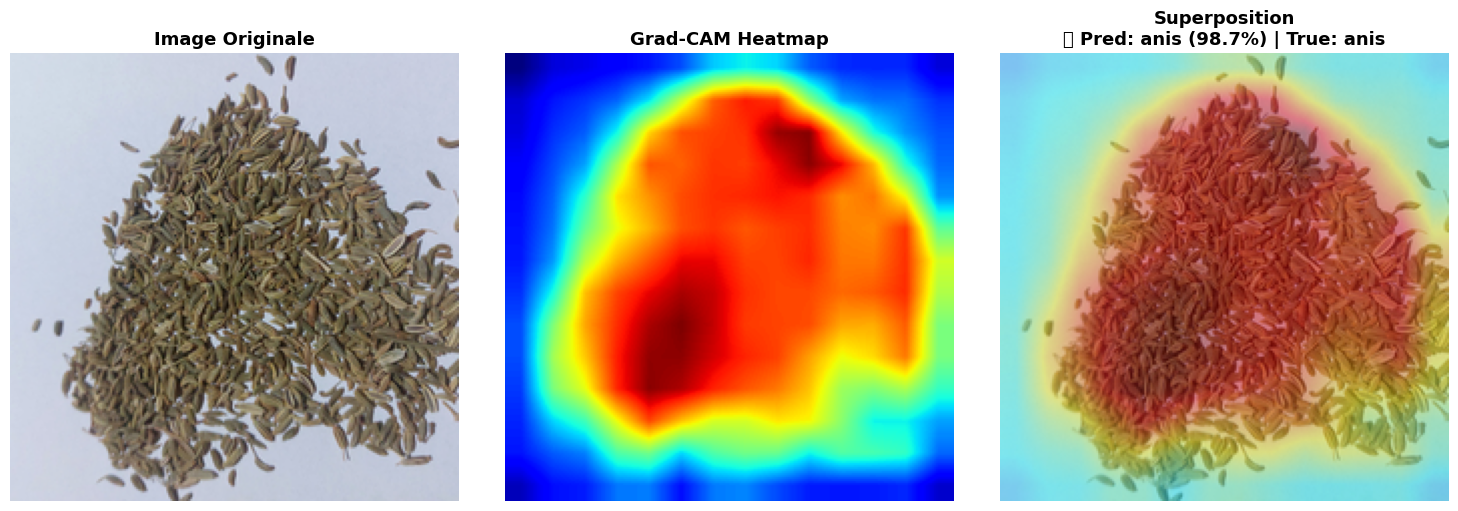

   1. ✅ Pred: anis (98.7%) | True: anis


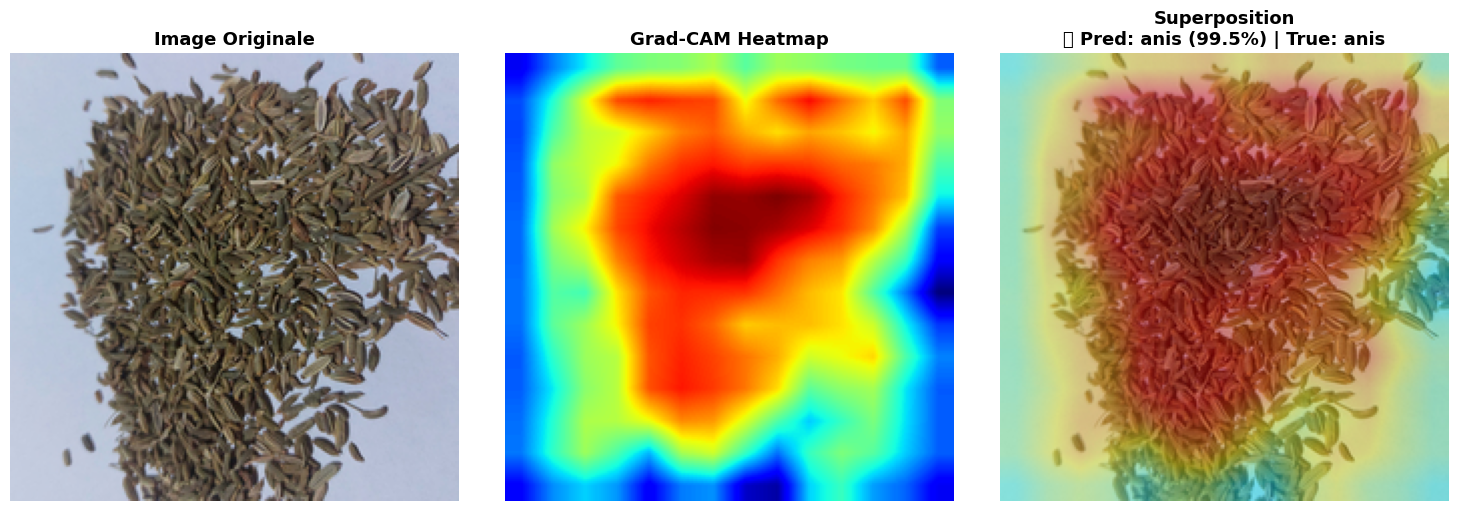

   2. ✅ Pred: anis (99.5%) | True: anis


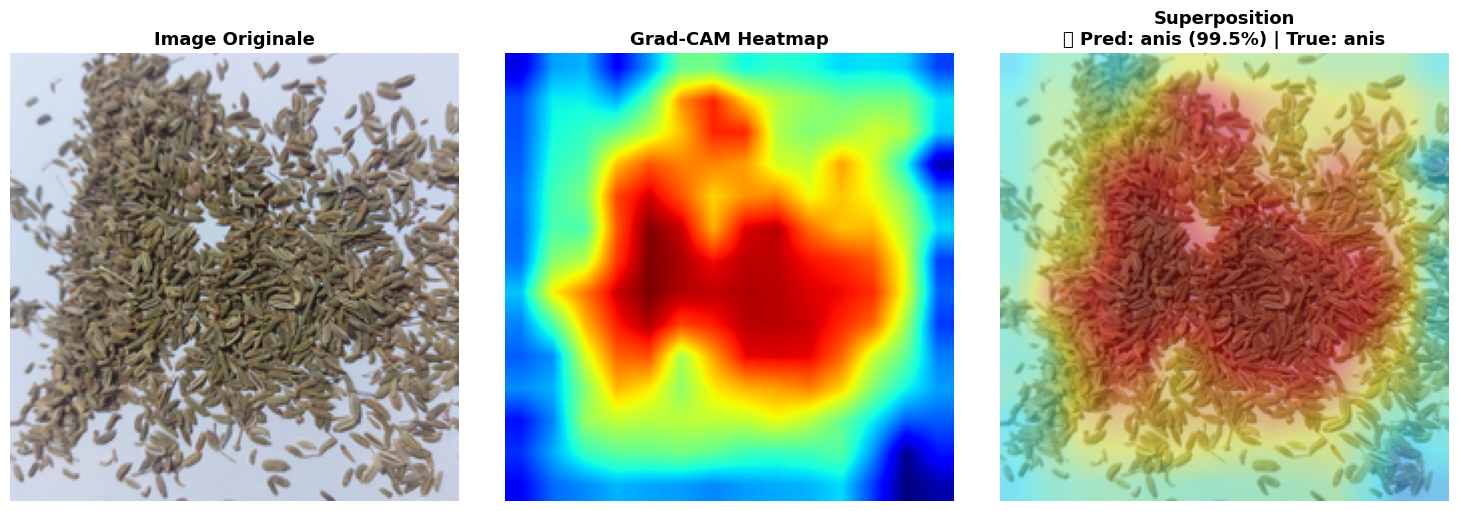

   3. ✅ Pred: anis (99.5%) | True: anis


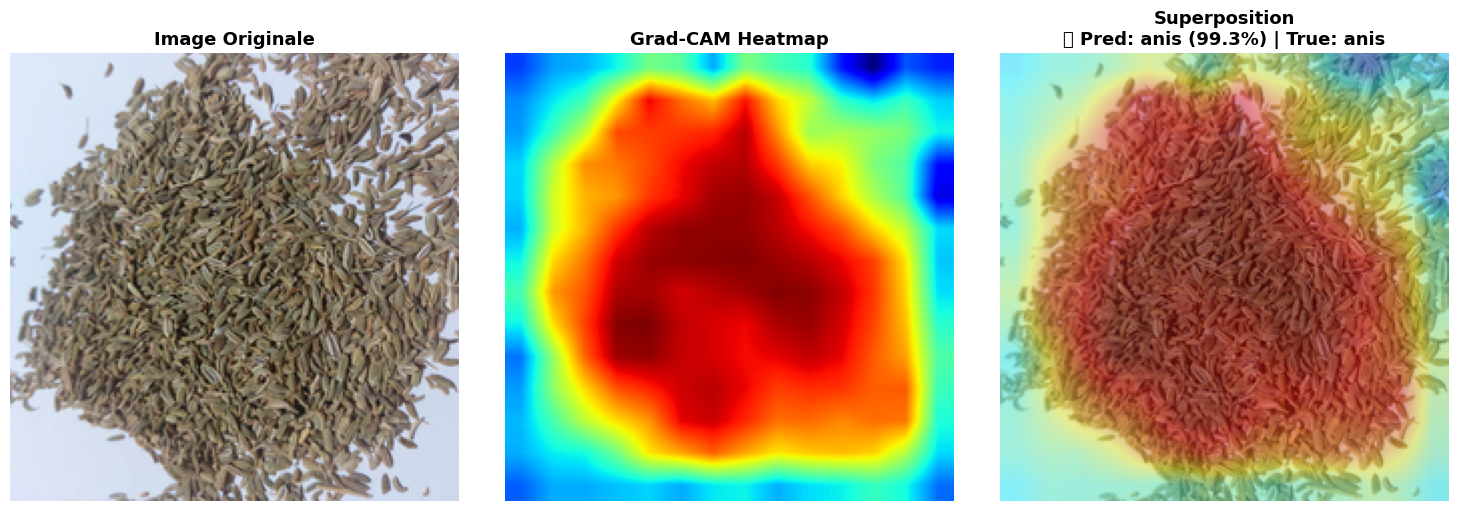

   4. ✅ Pred: anis (99.3%) | True: anis


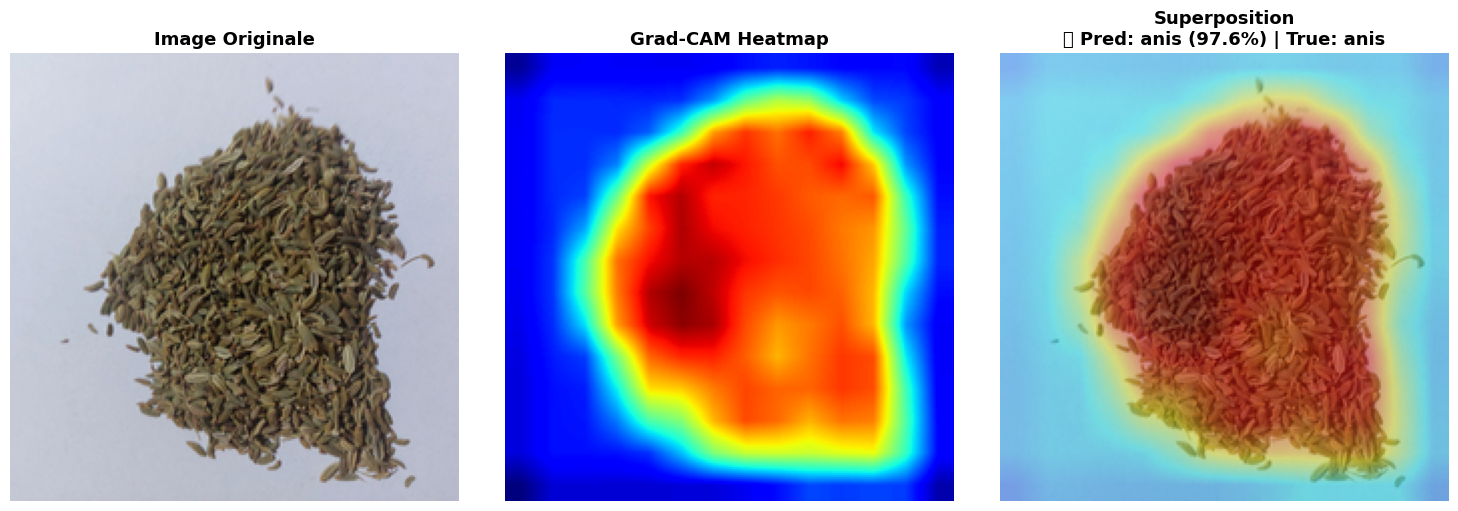

   5. ✅ Pred: anis (97.6%) | True: anis

✅ 5 visualisations Grad-CAM générées et sauvegardées


In [27]:
# ====================================
# VISUALISATION GRAD-CAM
# ====================================
print("\n🎨 Génération des visualisations Grad-CAM...\n")

# Récupérer quelques exemples du test set
model.eval()
dataiter = iter(test_loader)
images, labels = next(dataiter)

num_examples = min(5, len(images))

for i in range(num_examples):
    image = images[i]
    true_label = labels[i].item()
    
    # Prédiction
    with torch.no_grad():
        output = model(image.unsqueeze(0).to(device))
        pred_label = output.argmax(1).item()
        confidence = torch.softmax(output, dim=1)[0, pred_label].item()
    
    # Générer Grad-CAM sur la classe prédite
    cam = generate_gradcam(model, image, pred_label)
    
    # Créer le titre
    pred_class = train_dataset.class_names[pred_label]
    true_class = train_dataset.class_names[true_label]
    is_correct = "✅" if pred_label == true_label else "❌"
    title = f"{is_correct} Pred: {pred_class} ({confidence*100:.1f}%) | True: {true_class}"
    
    # Afficher
    show_gradcam(image, cam, title, save_path=f'../models/gradcam_example_{i+1}.png')
    
    print(f"   {i+1}. {title}")

print(f"\n✅ {num_examples} visualisations Grad-CAM générées et sauvegardées")

## 7. Sauvegarde des Résultats

In [28]:
# ====================================
# SAUVEGARDE DES RÉSULTATS
# ====================================
print("\n💾 Sauvegarde des résultats finaux...\n")

results = {
    'model': 'CNN Custom',
    'architecture': {
        'blocks': 4,
        'channels': '3→64→128→256→512',
        'total_params': int(total_params),
        'trainable_params': int(trainable_params)
    },
    'training': {
        'epochs': num_epochs,
        'batch_size': batch_size,
        'optimizer': 'Adam',
        'learning_rate': 0.001,
        'scheduler': 'ReduceLROnPlateau'
    },
    'performance': {
        'best_val_acc': float(best_val_acc),
        'test_acc': float(test_acc),
        'best_epoch': int(checkpoint['epoch'])
    },
    'dataset': {
        'num_classes': len(train_dataset.class_names),
        'class_names': train_dataset.class_names,
        'train_size': len(train_dataset),
        'val_size': len(val_dataset),
        'test_size': len(test_dataset)
    },
    'history': {
        'train_loss': [float(x) for x in history['train_loss']],
        'train_acc': [float(x) for x in history['train_acc']],
        'val_loss': [float(x) for x in history['val_loss']],
        'val_acc': [float(x) for x in history['val_acc']]
    }
}

# Sauvegarder en JSON
with open('../models/results_cnn_custom.json', 'w', encoding='utf-8') as f:
    json.dump(results, f, indent=2, ensure_ascii=False)

print("✅ Résultats sauvegardés dans: ../models/results_cnn_custom.json")
print("\n📊 Résumé Final:")
print("="*60)
print(f"   Modèle: CNN Custom ({total_params:,} paramètres)")
print(f"   Meilleure Val Accuracy: {best_val_acc:.2f}% (Epoch {checkpoint['epoch']})")
print(f"   Test Accuracy: {test_acc:.2f}%")
print(f"   Classes: {len(train_dataset.class_names)}")
print("="*60)
print("\n✅ Tous les résultats ont été sauvegardés avec succès!")


💾 Sauvegarde des résultats finaux...

✅ Résultats sauvegardés dans: ../models/results_cnn_custom.json

📊 Résumé Final:
   Modèle: CNN Custom (4,823,371 paramètres)
   Meilleure Val Accuracy: 76.06% (Epoch 27)
   Test Accuracy: 85.45%
   Classes: 11

✅ Tous les résultats ont été sauvegardés avec succès!
